In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sb
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as mpl
import math as m

In [2]:
figsize(15,15)


In [3]:
sb.set()

# Загрузка данных

In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [5]:
dir(newsgroups_train)

['DESCR', 'data', 'filenames', 'target', 'target_names']

# Создание датасетов

Для начала нужно сбросить убрать из словаря поля, которые не имеют той же длины, что и основные значения датасета. Информация взята [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

In [6]:
DESCR_train = newsgroups_train.pop('DESCR')
target_names_train = newsgroups_train.pop('target_names')

DESCR_test = newsgroups_test.pop('DESCR')
target_names_test = newsgroups_test.pop('target_names')

Теперь сделаем и данных датасеты

In [7]:
newsgroups_train_df = pd.DataFrame(newsgroups_train)
newsgroups_train_df.head()

,data,filenames,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,14


In [8]:
newsgroups_test_df = pd.DataFrame(newsgroups_test)
newsgroups_test_df.head()

,data,filenames,target
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,19


# Подготовка данных

Дальше удалим у обоих датасетов колонку с именем файла, так как оно не должно влиять на само сообщение

In [9]:
newsgroups_train_df = newsgroups_train_df.drop(columns=['filenames'], axis=0)
newsgroups_test_df = newsgroups_test_df.drop(columns=['filenames'], axis=0)

Теперь посмотрим на то, что содержится в колонке данных

In [10]:
newsgroups_train_df.data[:4]

0    From: lerxst@wam.umd.edu (where's my thing)\nS...
1    From: guykuo@carson.u.washington.edu (Guy Kuo)...
2    From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3    From: jgreen@amber (Joe Green)\nSubject: Re: W...
Name: data, dtype: object

In [11]:
for i in range(5):
    print('-------------')
    print(newsgroups_train_df.data[i])
    print('-------------')



-------------
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





-------------
-------------
From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washingto

Это похоже на электронные письма, которые приходят в газетные редакции.

Для начала приведем все к нижнему регистру

In [12]:
newsgroups_train_df.data = newsgroups_train_df.data.apply(lambda text: text.lower())
newsgroups_test_df.data = newsgroups_test_df.data.apply(lambda text: text.lower())

Теперь нужно очистить текст от лишних фрагментов. В каждом письме повторяется несколько блоков:
- From - от кого письмо, скорее всего не должно влиять на тему, потому что организации могут менять адреса или это может быть физическое лицо
- Subject - тема письма. Может оказывать влияние на цель письма
- Keywords - ключевые слова в письме. Может влиять на цель письма
- Organization - кто послал, скорее всего не влияет на класс. Так как одни и те же организации могут слать письма разного характера
- Lines - что то, наверное, длинна письма в строках
- Distribution - наверное, сфера распространения, не уверен во влиянии
- NNTP-Posting-Host - какой адрес в сети использован для отправления. Не влияет 
- Article-I.D. какой то ID, не влияет
- X-Newsreader - система отправления, не влияет

Нужно почистить шапки и оставить тему письма и ключевые слова

In [13]:
def clear_head(text: str) -> str:
    # Уберем заголовки тех частей, которые оставляем
    target_head_reg = re.compile('(subject|keywords):([\s]*[a-z_\-A-z]+:)?')
    text = target_head_reg.sub('', text)

    # Шаблон для полей заголовка
    head_reg = re.compile('[a-z_\-A-z<>\- _@\.\d,()]+:.*\n')
    text = head_reg.sub('', text)
    return text

In [14]:
clear_head(newsgroups_train_df.data[0])

' what car is this!?\n\n i was wondering if anyone out there could enlighten me on this car i saw\nthe other day. it was a 2-door sports car, looked to be from the late 60s/\nearly 70s. it was called a bricklin. the doors were really small. in addition,\nthe front bumper was separate from the rest of the body. this is \nall i know. if anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nthanks,\n- il\n   ---- brought to you by your neighborhood lerxst ----\n\n\n\n\n'

Похоже, что работает. Теперь применю к обоим датасетам

In [15]:
newsgroups_train_df.data = newsgroups_train_df.data.apply(clear_head)
newsgroups_test_df.data = newsgroups_test_df.data.apply(clear_head)

In [16]:
newsgroups_train_df
newsgroups_test_df

,data,target
0,need info on 88-89 bonneville\n\n\n i am a li...,7
1,x-face?\n\ni'm not familiar at all with the f...,5
2,strong & weak atheism\n\n> did that faq ever ...,0
3,saudi clergy condemns debut of human rights g...,17
4,"after 2000 years, can we say that christian m...",19
...,...,...
7527,temperature of the dark sky\n\n> does anyone ...,14
7528,monitors - should they be kept on 24 hours a ...,4
7529,\ni sent a version of this post out a while ag...,9
7530,intel chmos 8086/8088 design kit\n\n\n1)\t82c...,6


In [17]:
newsgroups_train_df.data[4]

' shuttle launch question\n\n>>in article <c5jlwx.4h9.1@cs.cmu.edu>, etrat@ttacs1.ttu.edu (pack rat) writes...\n>>>"clear caution & warning memory.  verify no unexpected\n>>>errors. ...".  i am wondering what an "expected error" might\n>>>be.  sorry if this is a really dumb question, but\n> \n> parity errors in memory or previously known conditions that were waivered.\n>    "yes that is an error, but we already knew about it"\n> i\'d be curious as to what the real meaning of the quote is.\n> \n> tom\n\n\nmy understanding is that the \'expected errors\' are basically\nknown bugs in the warning system software - things are checked\nthat don\'t have the right values in yet because they aren\'t\nset till after launch, and suchlike. rather than fix the code\nand possibly introduce new bugs, they just tell the crew\n\'ok, if you see a warning no. 213 before liftoff, ignore it\'.\n\n - jonathan\n\n\n'

Теперь нужно удалить изо всех писем прощальную часть, так как она не несет в себе никакого смысла

In [18]:
newsgroups_train_df.data[2]


' pb questions...\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing\na 180 if i got the 80mb disk rather than the 120, but i don\'t really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is that all "wow" or is it really that g

In [19]:
def clear_footer(text: str) -> str:
    footer_reg = re.compile('[\n]{2}(.+\n)+[\s]*$')
    text = footer_reg.sub('', text)
    return text

In [20]:
newsgroups_train_df.data[2]

' pb questions...\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing\na 180 if i got the 80mb disk rather than the 120, but i don\'t really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is that all "wow" or is it really that g

In [21]:
for i in range(5):
  print(newsgroups_train_df.data[i])
  print('________')
  print(clear_footer(newsgroups_train_df.data[i]))
  print('==========')

 what car is this!?

 i was wondering if anyone out there could enlighten me on this car i saw
the other day. it was a 2-door sports car, looked to be from the late 60s/
early 70s. it was called a bricklin. the doors were really small. in addition,
the front bumper was separate from the rest of the body. this is 
all i know. if anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

thanks,
- il
   ---- brought to you by your neighborhood lerxst ----





________
 what car is this!?

 i was wondering if anyone out there could enlighten me on this car i saw
the other day. it was a 2-door sports car, looked to be from the late 60s/
early 70s. it was called a bricklin. the doors were really small. in addition,
the front bumper was separate from the rest of the body. this is 
all i know. if anyone can tellme a model name, engine specs, years
of production, where this car is mad

Оно работает, теперь можно применять на все данные

In [22]:
newsgroups_train_df.data = newsgroups_train_df.data.apply(clear_footer)
newsgroups_test_df.data = newsgroups_test_df.data.apply(clear_footer)

Теперь обработаем остальные моменты

In [23]:
%pip install nltk
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VPR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def process_rest(text: str) -> str:
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'сайт', text)
    text = re.sub('[\W]+', ' ', text)
    stop_words = stopwords.words('english')
    tokens = word_tokenize(text)

    filtered_tokens = []

    for token in tokens:
        if token in stop_words:
            continue
        filtered_tokens.append(token)
    
    stemmer = SnowballStemmer('english')
    filtered_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return ' '.join(filtered_tokens)

In [25]:
newsgroups_train_df.data = newsgroups_train_df.data.apply(process_rest)
newsgroups_test_df.data = newsgroups_test_df.data.apply(process_rest)

In [26]:
x_train = newsgroups_train_df.data
y_train = newsgroups_train_df.target

x_test = newsgroups_test_df.data
y_test = newsgroups_test_df.target

# Обучение моделей

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Векторизация текста

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [30]:
x_train

<11314x57216 sparse matrix of type '<class 'numpy.float64'>'
	with 861157 stored elements in Compressed Sparse Row format>

In [31]:
scores = pd.DataFrame(columns=['name', 'score'])
results = {}


def learn_and_score(model, name: str,
                    X_train=x_train, X_test=x_test,
                    Y_train=y_train, Y_test=y_test,
                    retrain=False):

    score_slice = scores[scores['name'] == name]

    if len(score_slice) and not retrain:
        predicted = results.get(name)
        score = list(score_slice['score'])[0]
        return score, predicted

    model.fit(X_train, Y_train)
    predicted = model.predict(X_test)
    results[name] = predicted
    score = accuracy_score(Y_test, predicted)
    scores.loc[len(scores)] = [name, score]
    return score, predicted


def show_model_report(name, Y_test=y_test):
    predicted = results[name]
    score = list(scores[scores['name'] == name]['score'])[0]

    print(f'----{name}----')
    print(f'Model has {score} accuracy score')
    print('===================')
    print(classification_report(Y_test, predicted))
    sb.heatmap(confusion_matrix(Y_test, predicted), annot=True, fmt='.1f')


def show_total_report():
    sb.barplot(scores, x='name', y='score')

## Скалярные вектора

Попробуем метод скалярных векторов, возможно эти данные можно будет разделить с помощью векторов

In [32]:
from sklearn.svm import SVC

In [33]:
svc = SVC()
BASE_SVC = 'svc_base'
learn_and_score(svc, BASE_SVC)

(0.7858470525756771, array([ 7,  1,  0, ...,  9, 12, 15]))

----svc_base----
Model has 0.7858470525756771 accuracy score
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       319
           1       0.71      0.80      0.75       389
           2       0.77      0.70      0.73       394
           3       0.69      0.77      0.73       392
           4       0.86      0.80      0.83       385
           5       0.87      0.72      0.79       395
           6       0.64      0.84      0.73       390
           7       0.90      0.84      0.87       396
           8       0.88      0.90      0.89       398
           9       0.95      0.87      0.90       397
          10       0.96      0.91      0.94       399
          11       0.97      0.81      0.88       396
          12       0.66      0.77      0.71       393
          13       0.74      0.89      0.81       396
          14       0.87      0.86      0.86       394
          15       0.71      0.86      0.78       398
          16       0

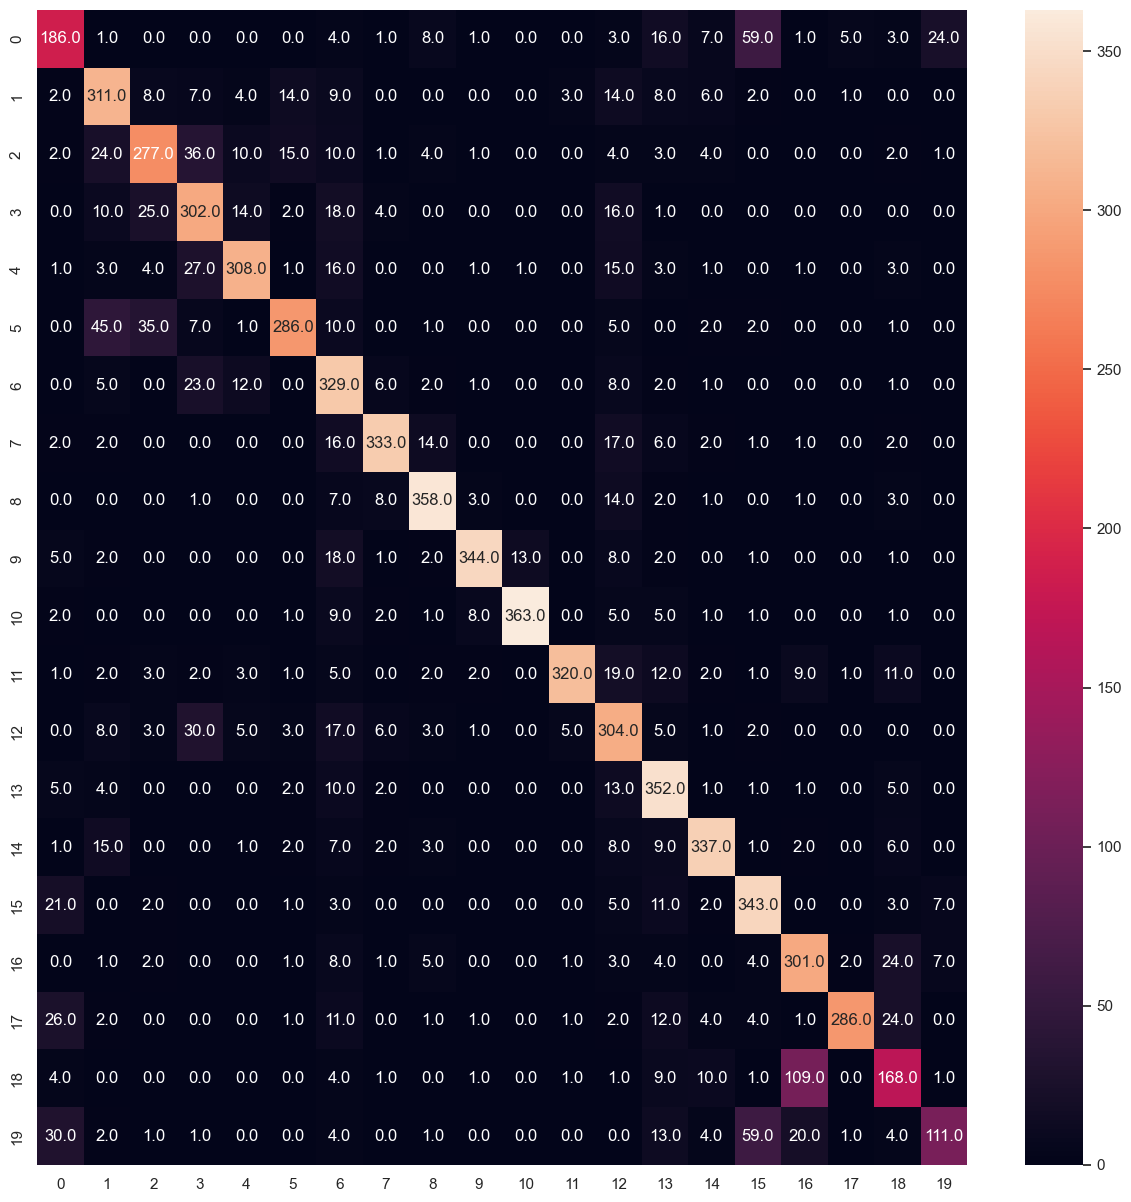

In [34]:
show_model_report(BASE_SVC)

Очень хороший результат, но на некоторых классах сильно проседает процент и модель учится довольно долго работает

## Случайный лес

Попробую случайный лес, как довольно универсальный алгоритм

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
random_forest = RandomForestClassifier(n_jobs=-1, random_state=42)
RANDOM_FOREST = 'base_random_forest'
learn_and_score(random_forest, RANDOM_FOREST)

(0.7298194370685077, array([ 4,  5,  0, ...,  9,  6, 15]))

----base_random_forest----
Model has 0.7298194370685077 accuracy score
              precision    recall  f1-score   support

           0       0.61      0.53      0.57       319
           1       0.62      0.66      0.64       389
           2       0.65      0.73      0.69       394
           3       0.66      0.71      0.69       392
           4       0.76      0.77      0.77       385
           5       0.75      0.68      0.71       395
           6       0.55      0.83      0.66       390
           7       0.78      0.79      0.79       396
           8       0.87      0.82      0.85       398
           9       0.83      0.86      0.85       397
          10       0.91      0.89      0.90       399
          11       0.90      0.85      0.87       396
          12       0.68      0.54      0.60       393
          13       0.78      0.75      0.76       396
          14       0.87      0.83      0.85       394
          15       0.60      0.85      0.70       398
          

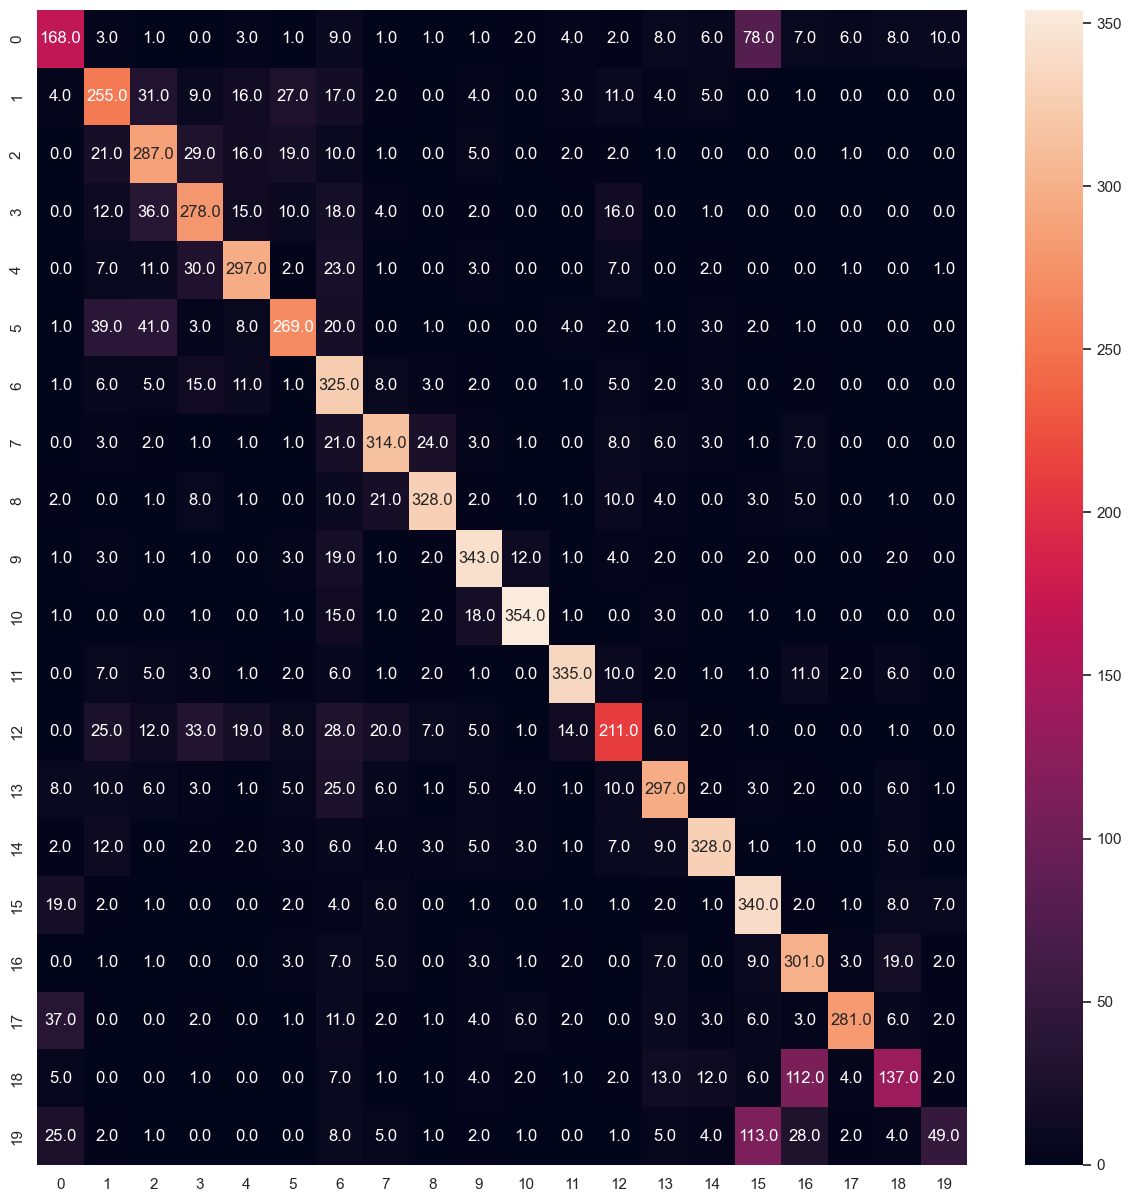

In [37]:
show_model_report(RANDOM_FOREST)

На удивление лес показал себя хуже, чем вектора. Тогда стоит вернуться к схожим с векторами алгоритмам

## Соседи

Попробую метод ближайших соседей, так как у него алгоритм схож с векторами

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
neighbors = KNeighborsClassifier(n_jobs=-1)
NEIGHBORS = 'base_neighbors'
learn_and_score(neighbors, NEIGHBORS)

(0.17233138608603293, array([7, 7, 7, ..., 7, 7, 7]))

----base_neighbors----
Model has 0.17233138608603293 accuracy score
              precision    recall  f1-score   support

           0       0.83      0.19      0.31       319
           1       0.86      0.16      0.28       389
           2       0.82      0.17      0.28       394
           3       0.85      0.21      0.34       392
           4       0.91      0.16      0.27       385
           5       0.84      0.13      0.22       395
           6       0.15      0.17      0.16       390
           7       0.06      0.97      0.12       396
           8       0.95      0.14      0.25       398
           9       0.98      0.11      0.19       397
          10       1.00      0.10      0.18       399
          11       0.97      0.08      0.15       396
          12       0.83      0.09      0.16       393
          13       1.00      0.10      0.19       396
          14       1.00      0.09      0.16       394
          15       0.90      0.05      0.09       398
          16 

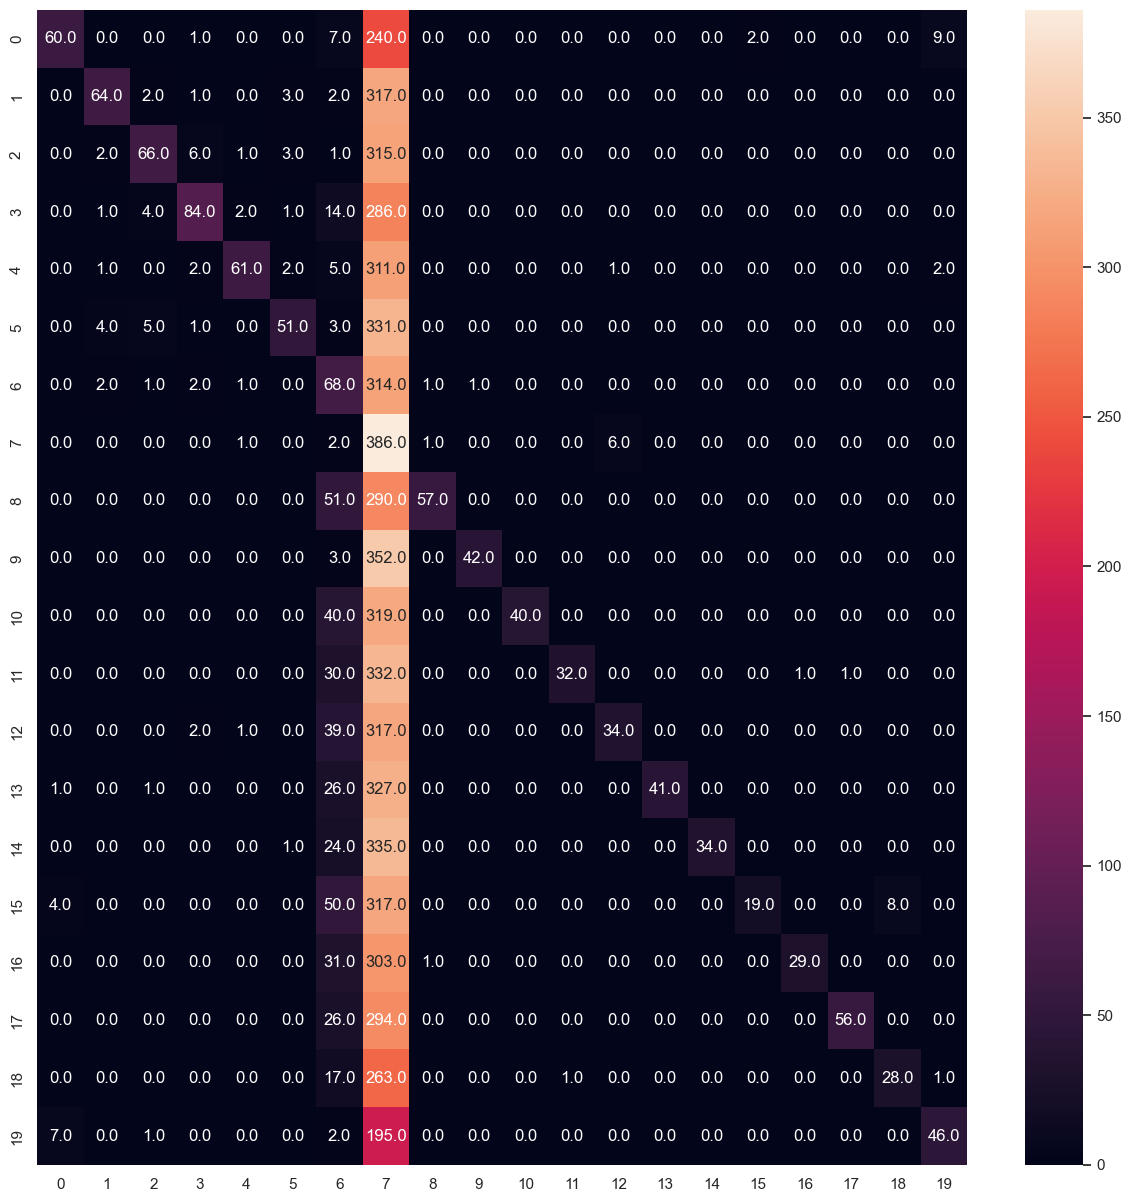

In [40]:
show_model_report(NEIGHBORS)

Модель показала себя очень плохо. Судя по всему все классы находятся довольно близко друг к другу, особенно с 7 

## Дерево решений

Изредка дерево в отдельности показывает себя лучше, чем лес. Так что проверим это

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
tree =DecisionTreeClassifier(random_state=42)
TREE ='base_tree'
learn_and_score(tree, TREE)

(0.5507169410515136, array([13,  5,  0, ..., 17,  6, 15]))

## 

----base_tree----
Model has 0.5507169410515136 accuracy score
              precision    recall  f1-score   support

           0       0.44      0.40      0.42       319
           1       0.46      0.47      0.46       389
           2       0.56      0.55      0.55       394
           3       0.43      0.47      0.45       392
           4       0.56      0.59      0.58       385
           5       0.57      0.51      0.54       395
           6       0.37      0.64      0.47       390
           7       0.64      0.56      0.59       396
           8       0.71      0.65      0.68       398
           9       0.68      0.64      0.66       397
          10       0.80      0.75      0.77       399
          11       0.74      0.68      0.71       396
          12       0.42      0.40      0.41       393
          13       0.52      0.53      0.53       396
          14       0.67      0.64      0.65       394
          15       0.56      0.57      0.57       398
          16       

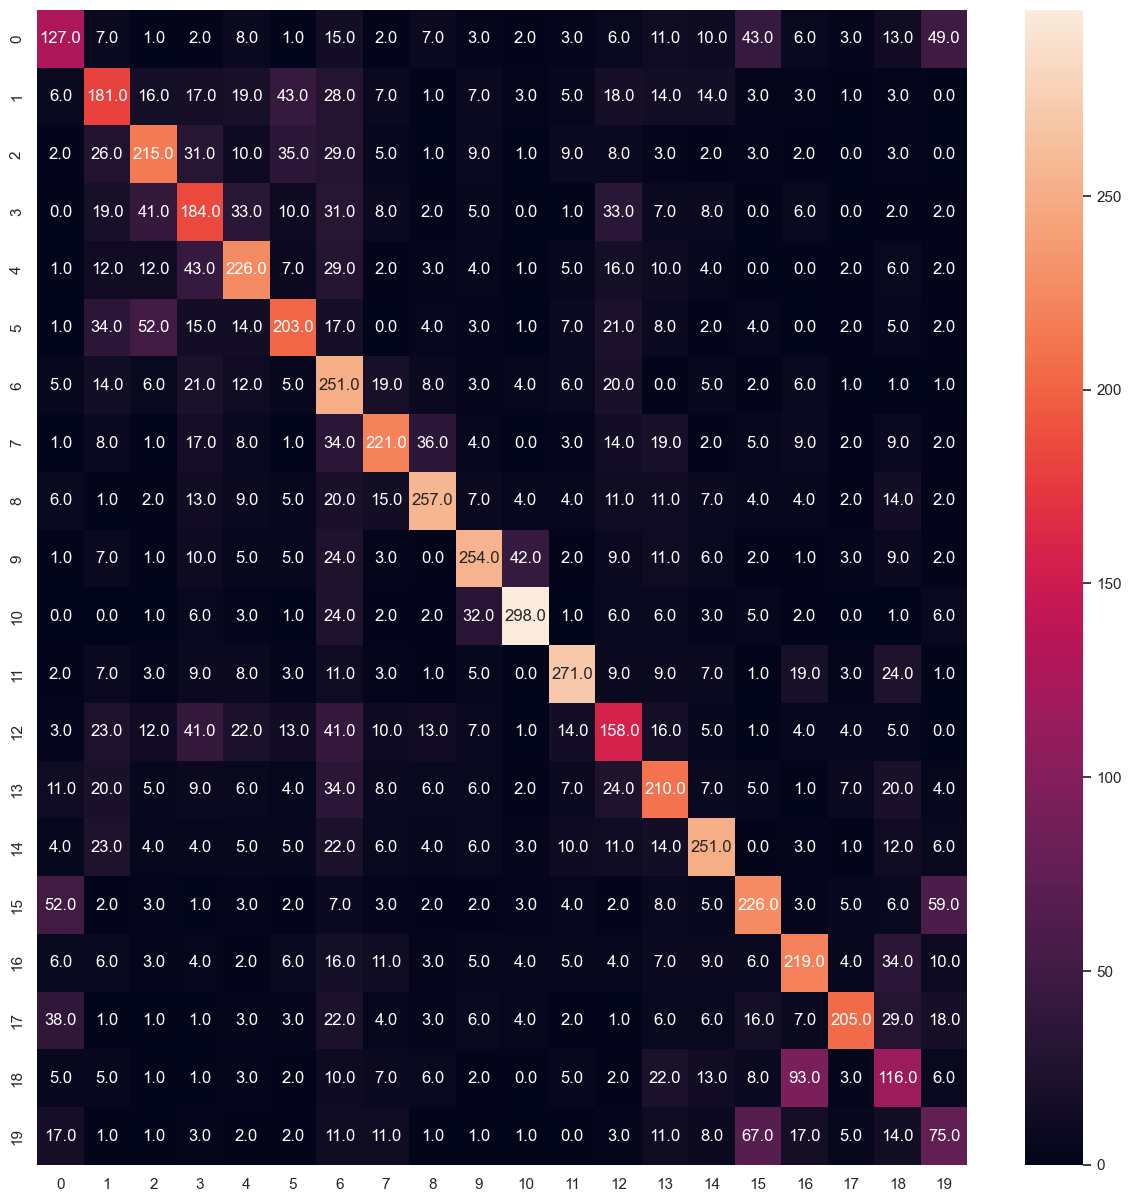

In [43]:
show_model_report(TREE)

В этот раз дерево показала себя хуже, чем лес целиком

## Наивный баес

Исходя из тематических ресурсов, наивный баес является довольно популярной нелинейной моделью для классификации

In [44]:
from sklearn.naive_bayes import MultinomialNB

In [45]:
bayes = MultinomialNB()
BAYES = 'base_bayes'
learn_and_score(bayes, BAYES)

(0.771109930961232, array([ 7,  5,  0, ..., 15,  3, 15]))

----base_bayes----
Model has 0.771109930961232 accuracy score
              precision    recall  f1-score   support

           0       0.84      0.38      0.52       319
           1       0.77      0.74      0.75       389
           2       0.75      0.75      0.75       394
           3       0.67      0.79      0.73       392
           4       0.81      0.81      0.81       385
           5       0.89      0.78      0.83       395
           6       0.90      0.65      0.76       390
           7       0.89      0.93      0.91       396
           8       0.90      0.84      0.87       398
           9       0.94      0.89      0.92       397
          10       0.90      0.97      0.93       399
          11       0.64      0.94      0.76       396
          12       0.81      0.61      0.70       393
          13       0.92      0.81      0.86       396
          14       0.86      0.89      0.87       394
          15       0.46      0.97      0.62       398
          16       

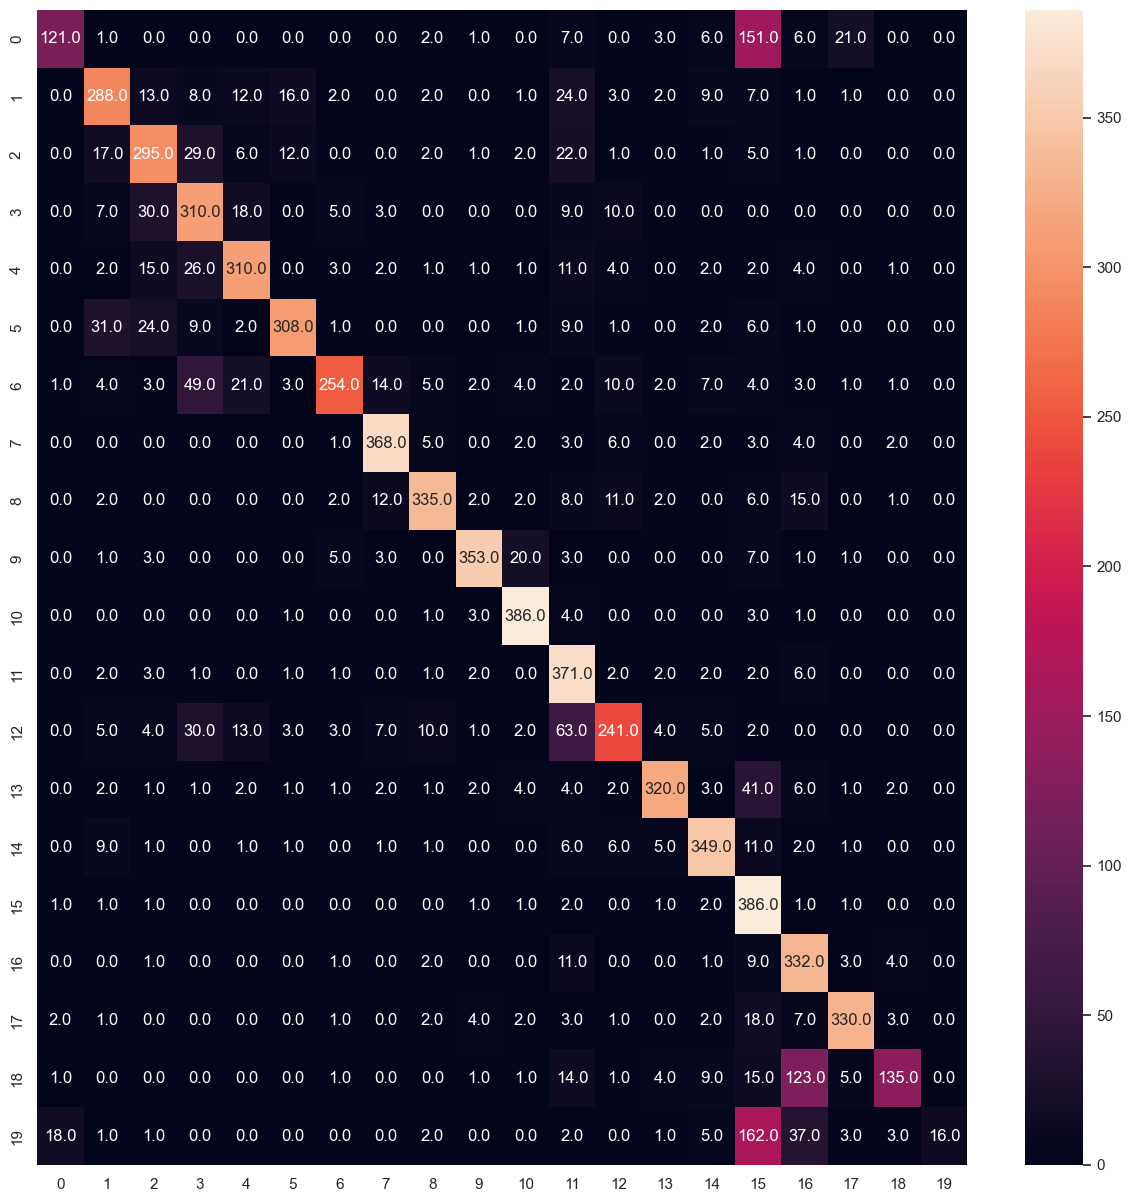

In [46]:
show_model_report(BAYES)

Точность практически на уровне векторов, но при этом время обучения сильно ниже, что очень выделяет его на фоне векторов

# Промежуточные итоги

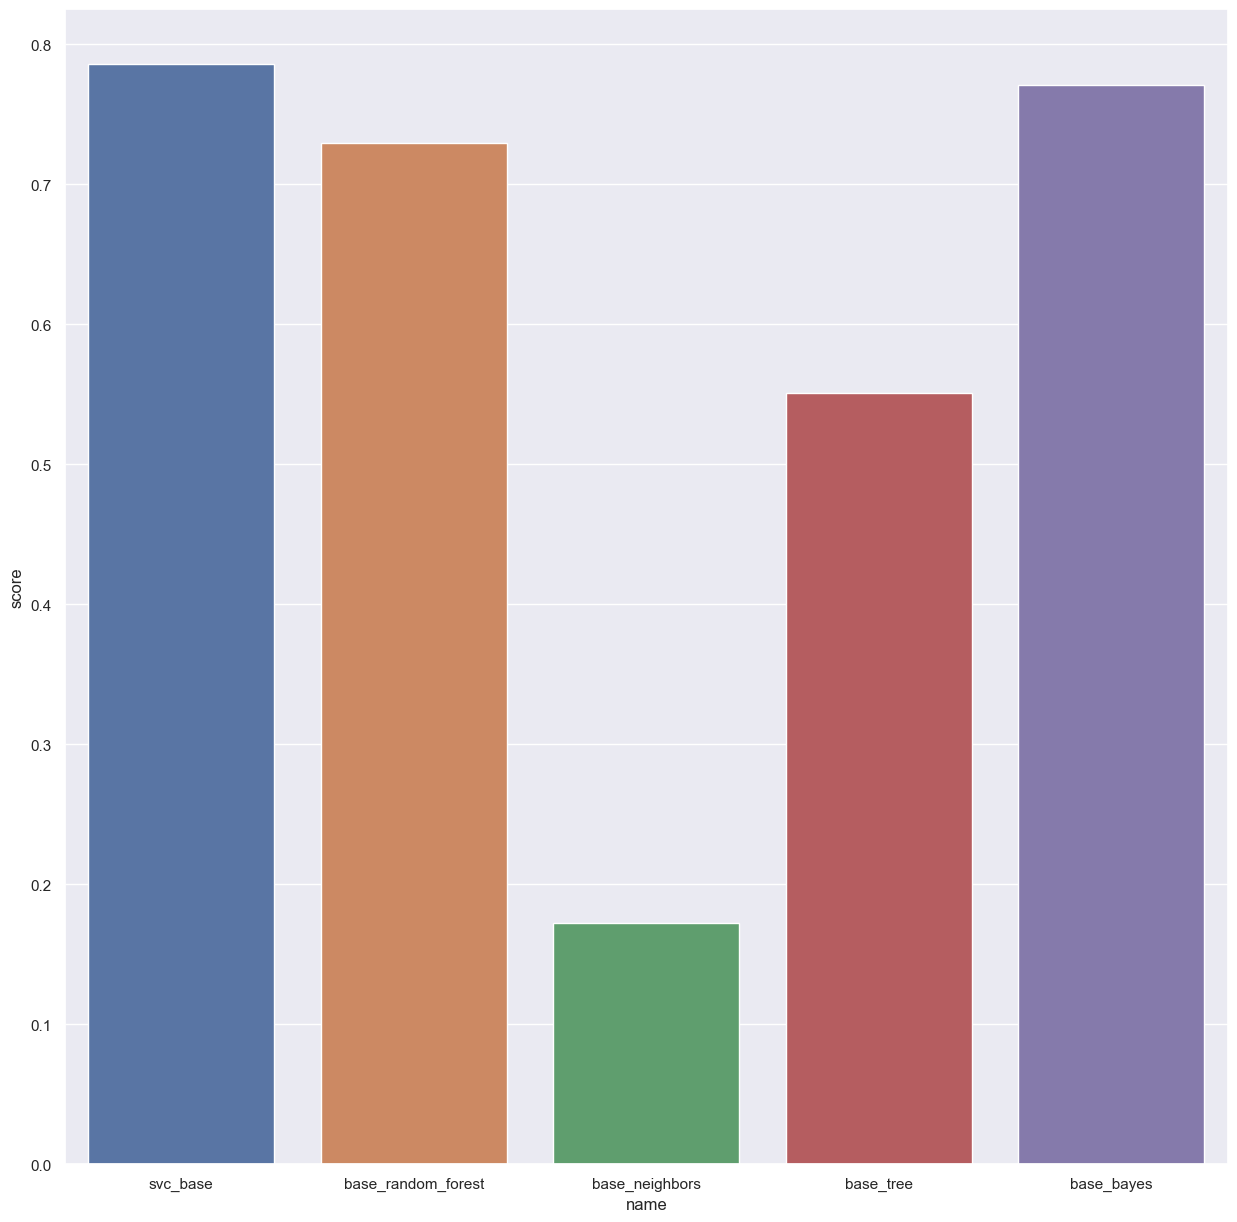

In [47]:
show_total_report()

Лучше всего себя показал баес и вектора, при этом баес так же имеет малое время обучения, что добавляет поводов выбрать его 

Теперь попробую улучшить вектора и баеса. Если получиться довести баеса до уровня базового вектора, то выбор будет однозначно за ним

# Улучшение моделей

In [48]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [49]:
def random_search(model, params):
    random = RandomizedSearchCV(
        model, params, cv=10, n_jobs=-1,
        random_state=42,
        n_iter=5,
        return_train_score=True)

    random.fit(x_train, y_train)

    results = pd.DataFrame(random.cv_results_).sort_values(by='mean_test_score', ascending=True)

    return  results, random

In [50]:
def grid_search(model, params):
    grid = GridSearchCV(
        model, params, cv=10, n_jobs=-1, 
        return_train_score=True)

    grid.fit(x_train, y_train)

    return grid.best_params_, grid

Вспомогательная функция для точного поиска параметров

In [51]:
IN_ROW = 3


def show_results(df: pd.DataFrame, in_row=IN_ROW):
    filtered_columns = list(filter(
        lambda column: column.startswith('param_'), df.columns))
    print(filtered_columns)
    rows_count = m.ceil(len(filtered_columns) / in_row)

    fig, axs = mpl.subplots(ncols=in_row, nrows=rows_count)
    sb.set(style='whitegrid', color_codes=True)
    fig.set_size_inches(30, 25)

    for index, column in enumerate(filtered_columns):
        row = index // in_row
        col = index  % in_row
        sb.barplot(x=column, y='mean_test_score', data=df,
                   ax=axs[row, col] if rows_count > 1 else axs[col])
    mpl.show()
    

Вспомогательная функция для отображения результатов по параметрам

## Баес

Для начала пройду случайным поиском, чтобы не сильно нагружать и найти более точные диапазоны поиска 

In [52]:
bayes_rand_param  = {
    'alpha': np.arange(0, 2, 0.2),
    'force_alpha': [True, False],
    'fit_prior': [True, False]
}

In [53]:
base_bayes = MultinomialNB()
prebest_bayes_results, _ = random_search(base_bayes, bayes_rand_param)

['param_force_alpha', 'param_fit_prior', 'param_alpha']


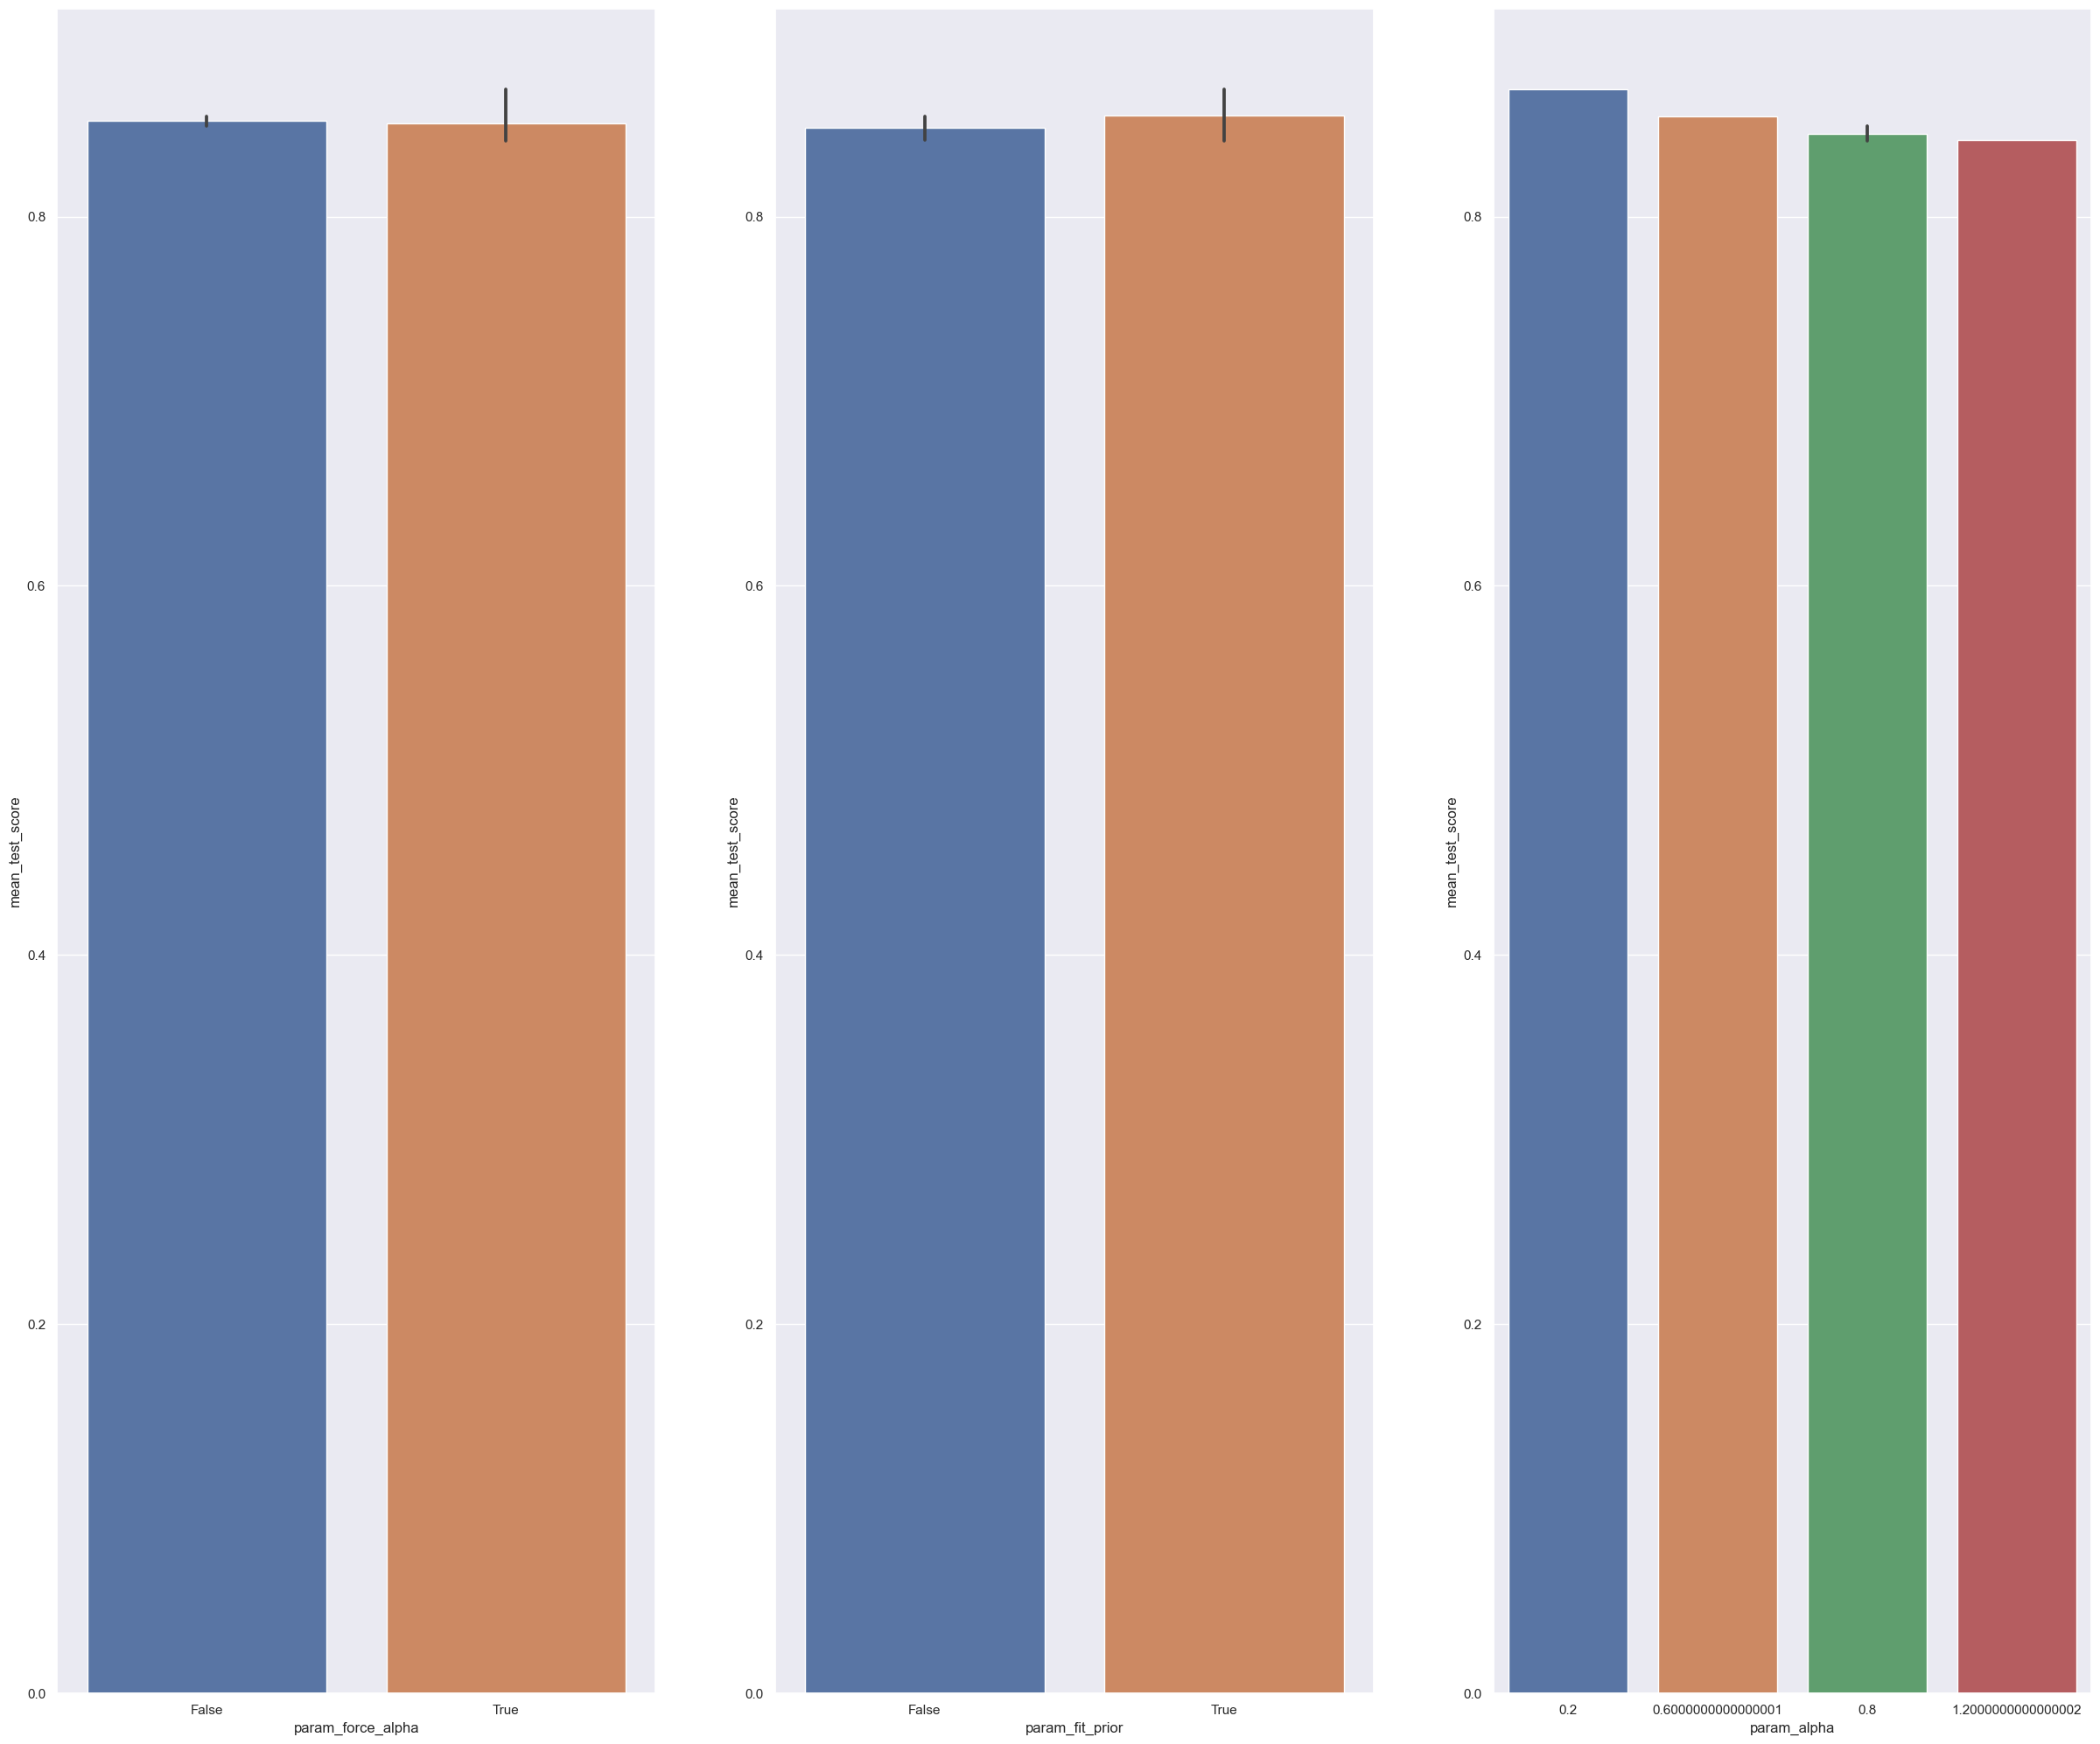

In [54]:
show_results(prebest_bayes_results)

Из графика выше точно можно взять такие параметры, как 
- force_alpha - True
- fit_prior - False
Нужно проверить:
- alpha - between 0 and 0.6

In [55]:
sure_best_bayes_params = {
    'force_alpha': True,
    'fit_prior': False
}

bayes_grid_params = {
    'alpha': np.arange(0, 0.6, 0.1)
}

In [56]:
prebest_bayes = MultinomialNB(**sure_best_bayes_params)
best_bayes_params, _ = grid_search(prebest_bayes, bayes_grid_params)

In [57]:
best_bayes = MultinomialNB(**sure_best_bayes_params, **best_bayes_params)
BEST_BAYES = 'best_bayes'
learn_and_score(best_bayes, BEST_BAYES)

(0.7992565055762082, array([ 7,  1,  0, ..., 16, 12, 15]))

----best_bayes----
Model has 0.7992565055762082 accuracy score
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       319
           1       0.75      0.78      0.77       389
           2       0.77      0.73      0.75       394
           3       0.70      0.78      0.74       392
           4       0.79      0.82      0.81       385
           5       0.88      0.80      0.84       395
           6       0.89      0.68      0.77       390
           7       0.89      0.92      0.91       396
           8       0.88      0.88      0.88       398
           9       0.94      0.91      0.92       397
          10       0.95      0.96      0.96       399
          11       0.76      0.92      0.83       396
          12       0.82      0.67      0.74       393
          13       0.92      0.84      0.88       396
          14       0.85      0.90      0.87       394
          15       0.61      0.94      0.74       398
          16      

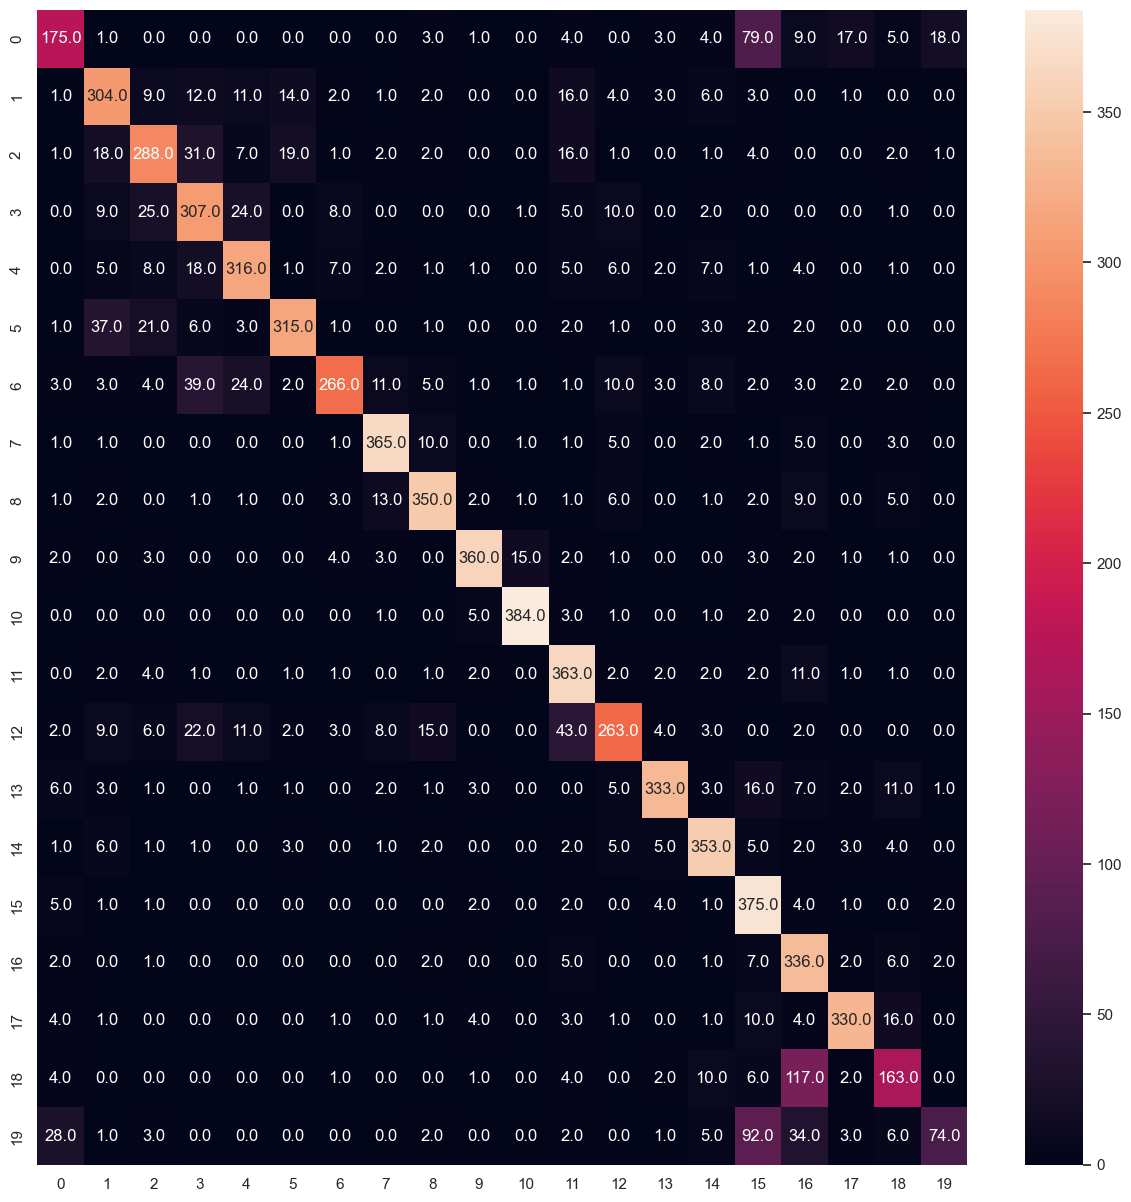

In [58]:
show_model_report(BEST_BAYES)

Модель стала работать куда лучше и уже обгоняет базовые вектора, сохраняя свою скорость работы. Скорее всего на нее падет выбор. Но попробую улучшить и вектора

## Вектора

Для начала пройду случайным поиском, чтобы не сильно нагружать и найти более точные диапазоны поиска 

In [59]:
svc_rand_param  = {
    'C': np.arange(0, 6, 1),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': np.arange(0, 30, 5),
    'coef0': np.arange(0, 5, 1),
    'shrinking': [True, False],
    'probability': [True, False],
    
}

In [60]:
base_svc = SVC()
svc_results, _ = random_search(base_svc, svc_rand_param)

['param_shrinking', 'param_probability', 'param_kernel', 'param_degree', 'param_coef0', 'param_C']


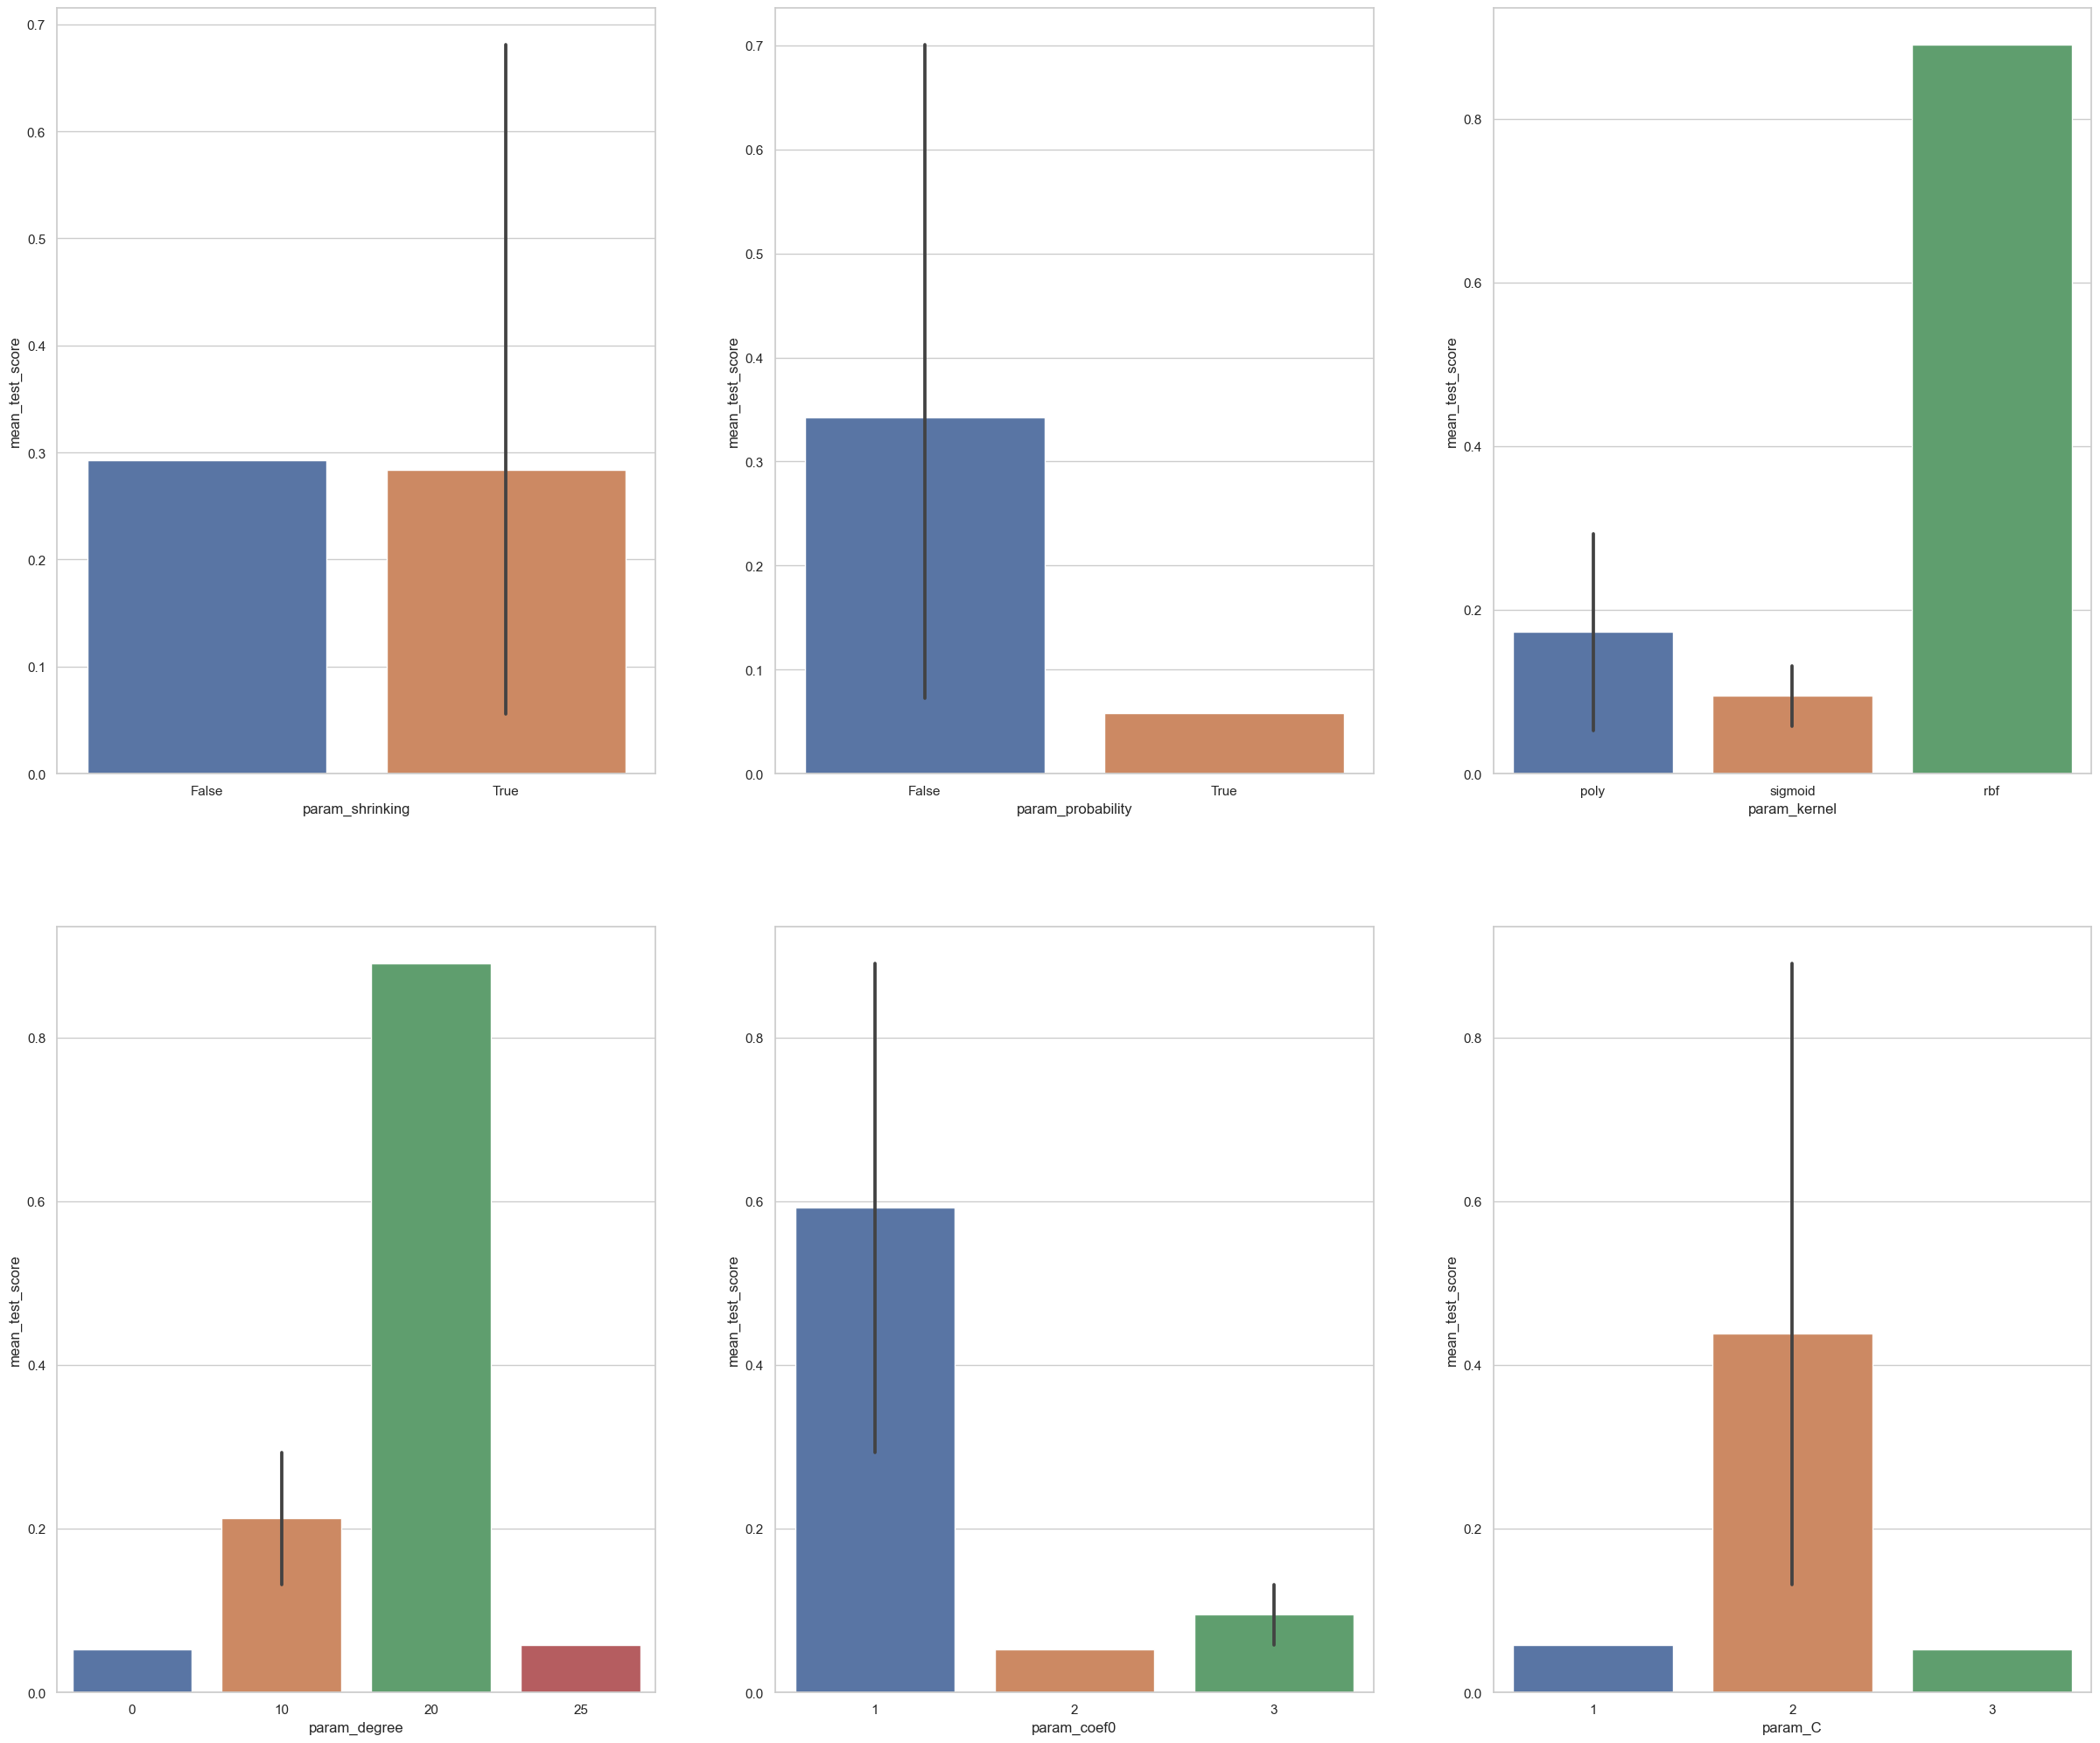

In [61]:
show_results(svc_results)

По графику точно можно сказать, что:
- shrinking - False
- C - 2
- kernel - rbf
- probability - False

Нужно еще посмотреть:
- degree - between 15 and 25

Не буду проверять:
- coef0 - because kernel is rbf


In [66]:
sure_best_svc_params = {
    'shrinking': False,
    'C': 2,
    'kernel': 'rbf',
    'probability': False
}

svc_grid_params = {
    'degree': np.arange(15, 25, 1)
}

In [67]:
prebest_svc =SVC(**sure_best_svc_params)
best_svc_params, _ = grid_search(prebest_svc, svc_grid_params)

In [68]:
best_svc = SVC(**sure_best_svc_params,**best_svc_params)
BEST_SVC='best_svc'
learn_and_score(best_svc, BEST_SVC)

(0.7923526287838556, array([ 7,  1,  0, ...,  9, 12, 15]))

----best_svc----
Model has 0.7923526287838556 accuracy score
              precision    recall  f1-score   support

           0       0.66      0.61      0.64       319
           1       0.72      0.80      0.76       389
           2       0.78      0.71      0.74       394
           3       0.70      0.78      0.74       392
           4       0.86      0.82      0.84       385
           5       0.86      0.73      0.79       395
           6       0.65      0.84      0.73       390
           7       0.91      0.85      0.88       396
           8       0.88      0.90      0.89       398
           9       0.95      0.87      0.91       397
          10       0.94      0.92      0.93       399
          11       0.95      0.82      0.88       396
          12       0.68      0.76      0.72       393
          13       0.75      0.90      0.82       396
          14       0.88      0.86      0.87       394
          15       0.72      0.86      0.79       398
          16       0

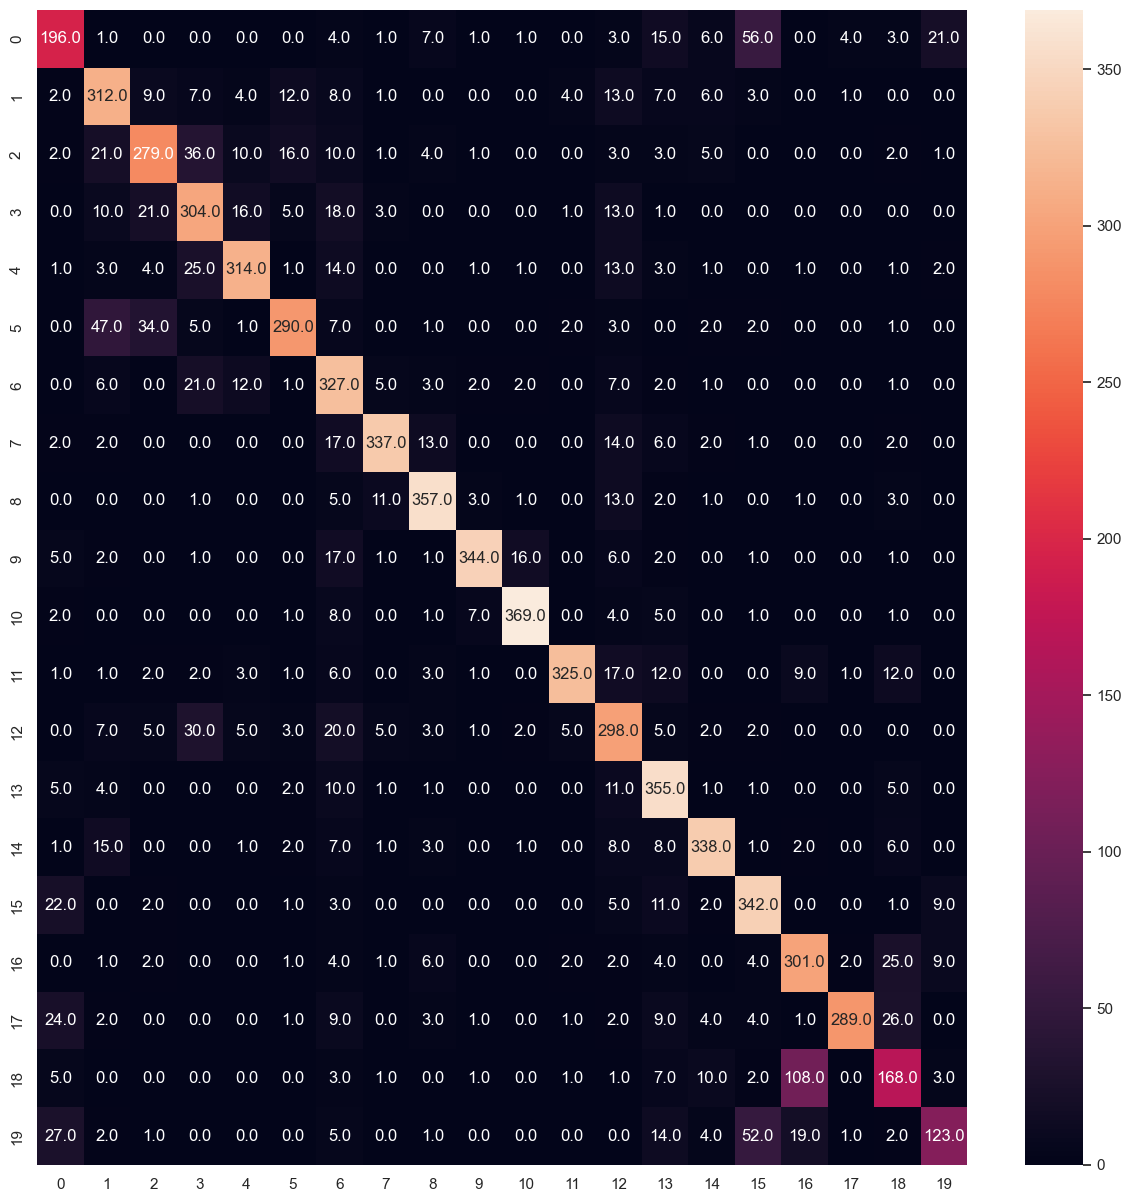

In [69]:
show_model_report(BEST_SVC)

Не получилось улучшить результаты, а долгое время работы делает модель не конкурентной

# Выводы

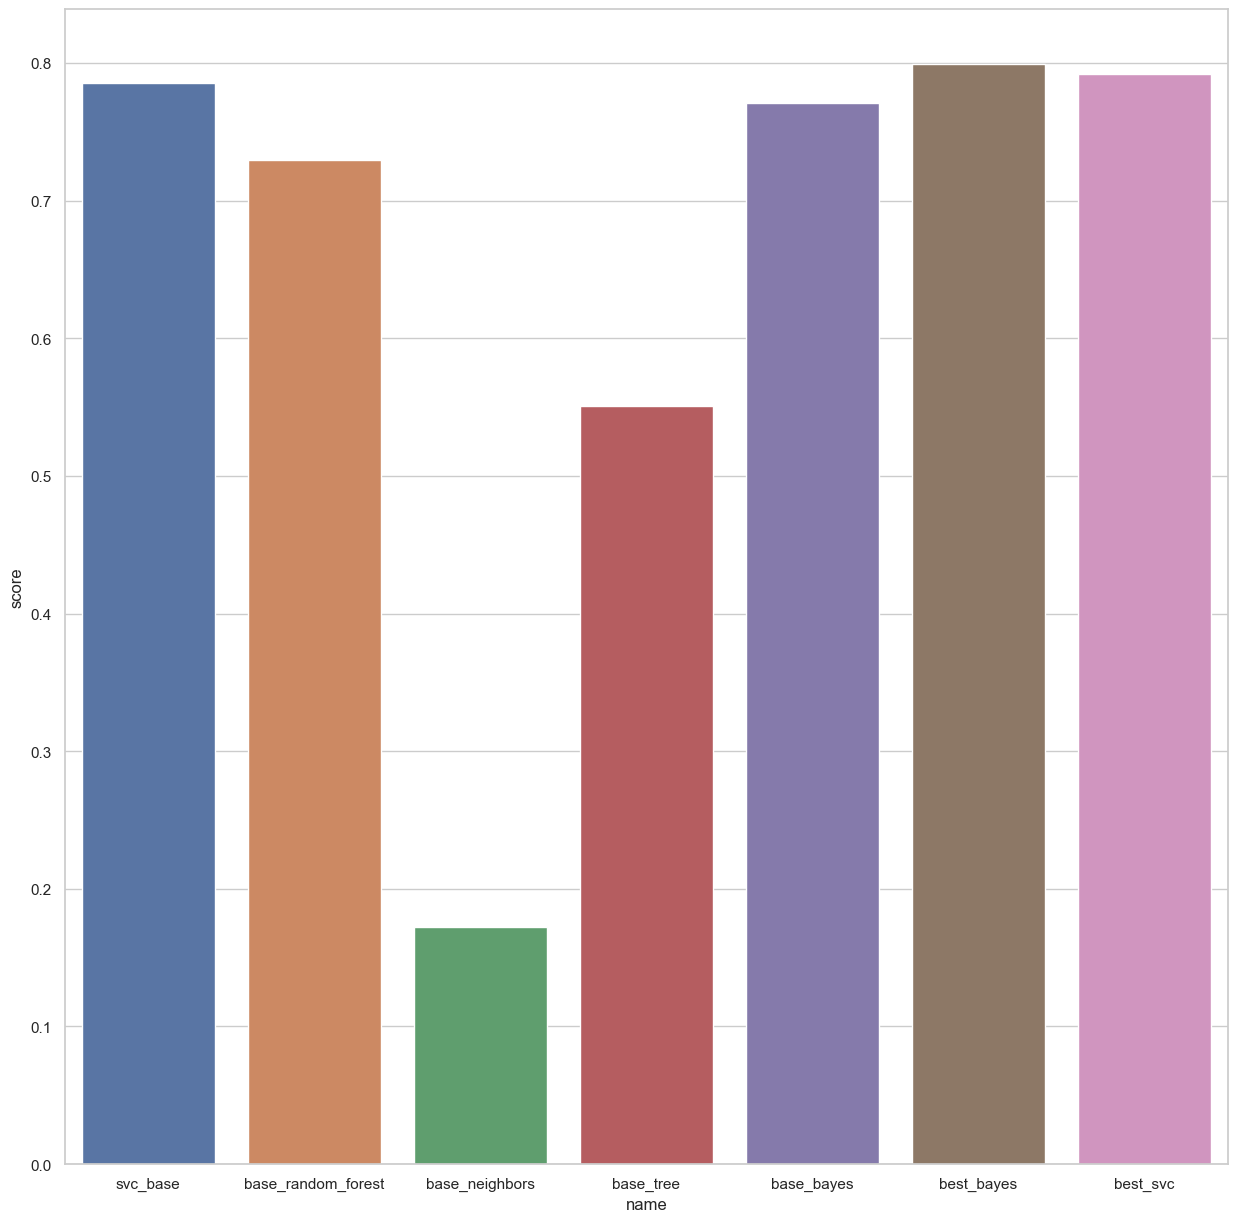

In [70]:
show_total_report()

Я выбираю улучшенную модель наивного баеса, потому что она работает быстро и точнее всего 

In [71]:
from joblib import dump

In [73]:
dump(best_bayes, './model.pkl')

['./model.pkl']